# Outline
- [ 1 - Little theory behind SVM](#1)
- [ 2 - Import Data and brief EDA](#2)
- [ 3 - Feature selection and train custom model](#3)
- [ 4 - Training sklearm model and fine tuning](#4)

SVM and Breast Chancer Dataset
<br> Dataset is provided by [`Kaggle Fake News Competition`](https://www.kaggle.com/competitions/fake-news/data)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
import seaborn as sns

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sergeiakhmadulin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
train = pd.read_csv("/Users/sergeiakhmadulin/My Drive/Fake news/train.csv", on_bad_lines='skip',sep=',')
evaluation_data = pd.read_csv("/Users/sergeiakhmadulin/My Drive/Fake news/test.csv", on_bad_lines='skip',sep=',')

In [3]:
train.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [4]:
for i in ["title", "author", "text"]:
    if i=="author":
        train[i] = train[i].fillna('unknown')
    train[i] = train[i].fillna('unknown')
    evaluation_data[i] = evaluation_data[i].fillna('unknown')

In [5]:
target_names = ["Unreliable", "Reliable"]

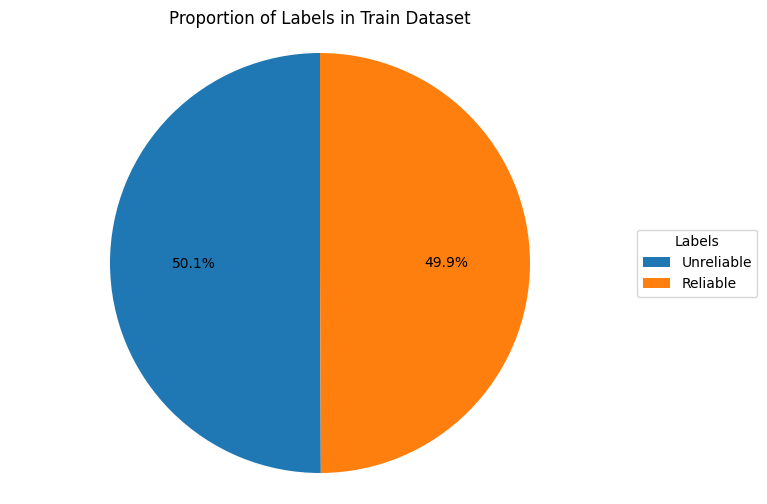

In [8]:
label_counts = train['label'].value_counts()

fig, ax = plt.subplots(figsize=(8,6))
wedges, texts, autotexts = ax.pie(label_counts, autopct='%1.1f%%', startangle=90)

ax.axis('equal')
ax.set_title('Proportion of Labels in Train Dataset')
ax.legend(wedges, target_names, title="Labels", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()

In [9]:
def plot_words_cloud(data, title):
    text = ' '.join(data)

    # Generate and display the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

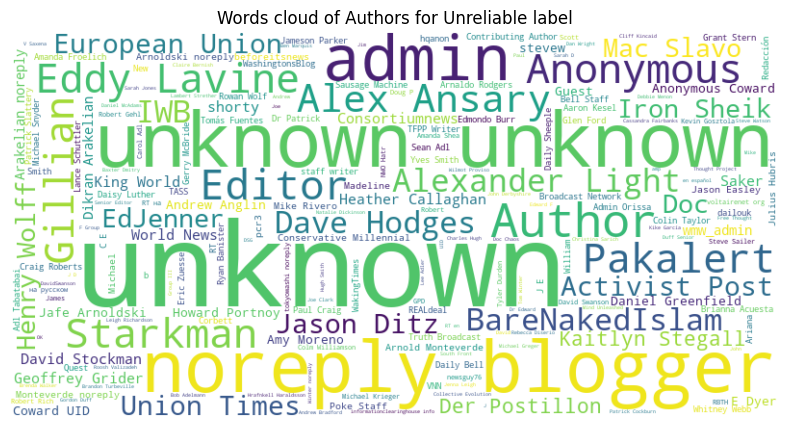

In [10]:
plot_words_cloud(train[train["label"]==1]["author"], "Words cloud of Authors for " + target_names[0] + " label")

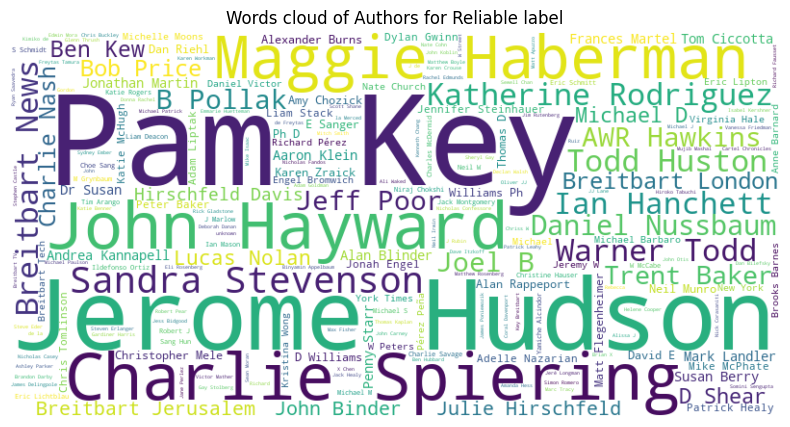

In [11]:
plot_words_cloud(train[train["label"]==0]["author"], "Words cloud of Authors for " + target_names[1] + " label")

In [12]:
def text_prepare(text, stemming = True):
    """
    Function that does a general text preparation

    Parameters:
    text: corpus of text documents

    Output:

    text without spetial characters, "stop words" in lower case and stemmed
    """
    stemmer = PorterStemmer()
    REPLACE_BY_SPACE_RE = re.compile(r'[^a-zA-Z0-9\s]')
    BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
    STOPWORDS = set(stopwords.words('english'))
    text = text.lower()

    text = REPLACE_BY_SPACE_RE.sub(r' ',text)
    text = BAD_SYMBOLS_RE.sub(r'',text)
    if stemming:
        text = [stemmer.stem(w) for w in text.split() if not w in STOPWORDS]
    else:
        text = [w for w in text.split() if not w in STOPWORDS]
    
    return ' '.join(text)

In [13]:
def plot_confusion_matrix(Y_true, Y_pred):
    cm = confusion_matrix(Y_true, Y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=list(proportions.columns), yticklabels=list(proportions.columns))
    
    # Set plot labels and title
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix Heatmap')
    plt.show()

For now let's combine train and validation datasets and use them together in training

In [14]:
train["all_test"] = train['title'] + " " + train["text"]
evaluation_data["all_test"] = evaluation_data['title'] + " " + evaluation_data["text"]

In [15]:
X_train, X_test, y_train, y_test = train_test_split(train.drop(columns=['label']),train['label'], test_size=0.2, random_state = 42)

In [16]:
X_train_cleaned = [text_prepare(x) for x in X_train["all_test"]]
X_test_cleaned = [text_prepare(x) for x in X_test["all_test"]]

In [17]:
tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1, 2))

In [18]:
X_train_matrix = tfidf.fit_transform(X_train_cleaned)
X_test_matrix = tfidf.transform(X_test_cleaned)

In [19]:
tfidf_reversed_vocab = {i:word for word,i in tfidf.vocabulary_.items()}

<a name="2"></a>
## 2 - ML models

In [20]:
from sklearn.calibration import CalibratedClassifierCV
svm_model = LinearSVC(C=10,random_state=42, max_iter=10000)
svm_model.fit(X_train_matrix, y_train)

LinearSVC(C=10, max_iter=10000, random_state=42)

In [23]:
calibrated_svc = CalibratedClassifierCV(svm_model, method='sigmoid', cv='prefit')

# Fit the calibrated model (calibration does not require a separate training set)
calibrated_svc.fit(X_train_matrix, y_train)

CalibratedClassifierCV(cv='prefit',
                       estimator=LinearSVC(C=10, max_iter=10000,
                                           random_state=42))

In [24]:
y_pred = svm_model.predict(X_test_matrix)

# Classification report to evaluate performance
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97      2132
           1       0.98      0.96      0.97      2028

    accuracy                           0.97      4160
   macro avg       0.97      0.97      0.97      4160
weighted avg       0.97      0.97      0.97      4160



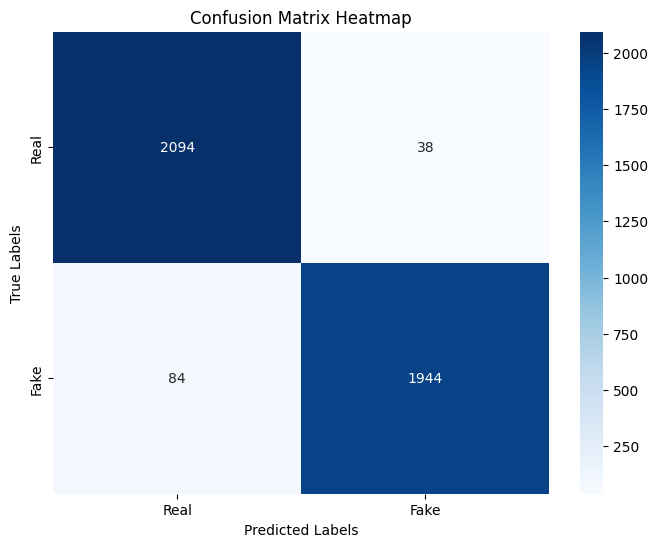

In [25]:
plot_confusion_matrix(y_test, y_pred)

In [27]:
nb_model = MultinomialNB()
nb_model.fit(X_train_matrix, y_train)

# Make predictions on the test set
y_pred_NB = nb_model.predict(X_test_matrix)

In [28]:
print("Classification Report:\n", classification_report(y_test, y_pred_NB))

Classification Report:
               precision    recall  f1-score   support

           0       0.80      1.00      0.89      2132
           1       1.00      0.74      0.85      2028

    accuracy                           0.87      4160
   macro avg       0.90      0.87      0.87      4160
weighted avg       0.90      0.87      0.87      4160



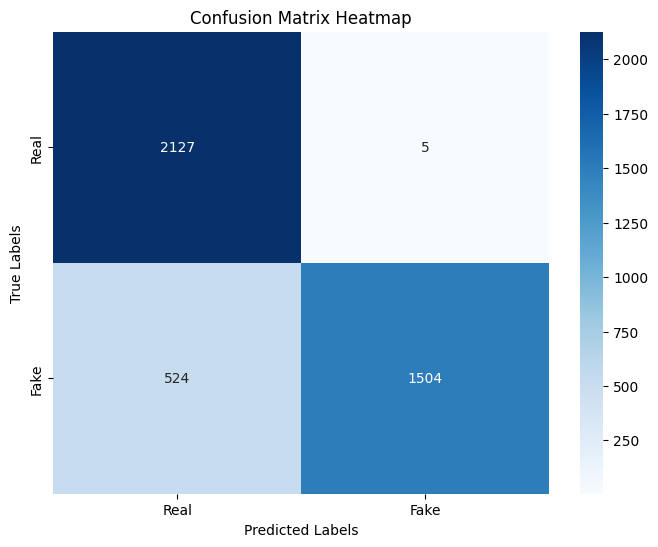

In [29]:
plot_confusion_matrix(y_test, y_pred_NB)

In [30]:
param_grid_LR = {
    'C': [0.001, 0.01, 0.1, 1, 10],            # Regularization strength
    'penalty': ['l2', 'l1'],                   # Regularization type
    'solver': ['liblinear']            # Solvers
}

grid_search_LR = GridSearchCV(LogisticRegression(), param_grid_LR, cv=5, n_jobs=-1, verbose=1)

# Fit GridSearchCV to the training data
grid_search_LR.fit(X_train_matrix, y_train)

best_lr_model = grid_search_LR.best_estimator_

# Make predictions with the tuned model
y_pred_LR = best_lr_model.predict(X_test_matrix)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [31]:
print("Classification Report:\n", classification_report(y_test, y_pred_LR))

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.97      2132
           1       0.98      0.96      0.97      2028

    accuracy                           0.97      4160
   macro avg       0.97      0.97      0.97      4160
weighted avg       0.97      0.97      0.97      4160



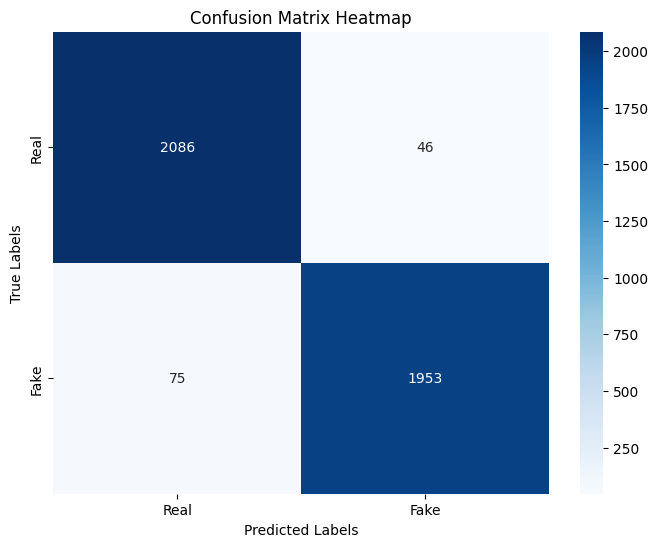

In [32]:
plot_confusion_matrix(y_test, y_pred_LR)

In [ ]:
min = np.argsort(best_lr_model.coef_[0])[:5]

In [ ]:
np.argsort(best_lr_model.coef_[0])[:5][::-1]

In [ ]:
best_lr_model.coef_[0][1358680]

In [41]:
calibrated_svc.predict_proba(X_test_matrix)[:,1]

array([9.99855849e-01, 9.99999813e-01, 5.50083450e-07, ...,
       9.99995701e-01, 7.24422865e-03, 9.99999908e-01])

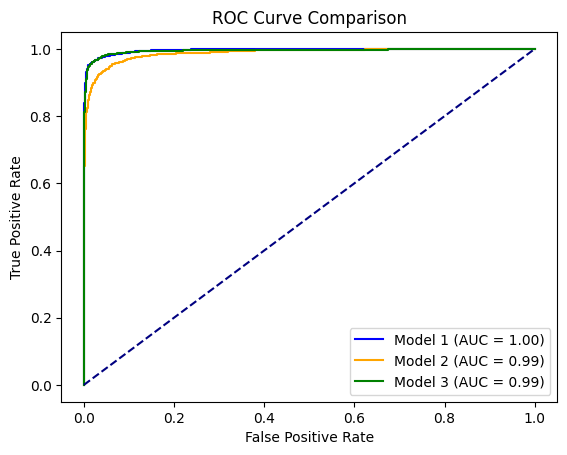

In [42]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calculate ROC curve and AUC for each model
fpr1, tpr1, _ = roc_curve(y_test, calibrated_svc.predict_proba(X_test_matrix)[:,1])
fpr2, tpr2, _ = roc_curve(y_test, nb_model.predict_proba(X_test_matrix)[:,1])
fpr3, tpr3, _ = roc_curve(y_test, best_lr_model.predict_proba(X_test_matrix)[:,1])

roc_auc1 = auc(fpr1, tpr1)
roc_auc2 = auc(fpr2, tpr2)
roc_auc3 = auc(fpr3, tpr3)

# Plot ROC curves
plt.figure()
plt.plot(fpr1, tpr1, color='blue', label=f'Model 1 (AUC = {roc_auc1:.2f})')
plt.plot(fpr2, tpr2, color='orange', label=f'Model 2 (AUC = {roc_auc2:.2f})')
plt.plot(fpr3, tpr3, color='green', label=f'Model 3 (AUC = {roc_auc3:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.show()

In [ ]:
def make_prediction(data):
    test_cleaned = [text_prepare(x) for x in data["all_test"]]
    tfidf_data = tfidf.transform(test_cleaned)
    y_pred_LR = best_lr_model.predict(tfidf_data)
    
    data.index = pd.RangeIndex(start=20800, stop=20800 + len(data), step=1)
    
    pred_data = pd.DataFrame({
    "id": data.index,
    'label': y_pred_LR
    })
    return pred_data

In [ ]:
file_to_submit = make_prediction(evaluation_data)

In [ ]:
file_to_submit.to_csv('Predict_LR.csv',index=False)

<a name="3"></a>
## 3 - Neuron Network

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, LSTM, Dropout

In [ ]:
def print_history(model, X, y):
    loss, accuracy = model.evaluate(X, y)
    print(f'Test Accuracy: {accuracy * 100:.2f}%')
    
    # Plot the training history
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
    # Make predictions and print classification report
    y_pred = model.predict(X)
    y_pred = (y_pred > 0.5).astype(int)
    print(classification_report(y_test, y_pred))

In [ ]:
X_train_NN = [text_prepare(x, stemming = False) for x in X_train["all_test"]]
X_test_NN = [text_prepare(x, stemming = False) for x in X_test["all_test"]]

In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train_NN)

In [ ]:
X_train_seq = tokenizer.texts_to_sequences(X_train_NN)
X_test_seq = tokenizer.texts_to_sequences(X_test_NN)

In [ ]:
X_train_pad = pad_sequences(X_train_seq, padding='post', maxlen=300)
X_test_pad = pad_sequences(X_test_seq, padding='post', maxlen=300)

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128))
model.add(Conv1D(filters=32, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_pad, y_train, epochs=5, batch_size=8, validation_data=(X_test_pad, y_test))

In [ ]:
print_history(model, X_test_pad, y_test)

In [ ]:
model_lstm = Sequential()

# Embedding layer to convert integer sequences to dense vectors
model_lstm.add(Embedding(input_dim=5000, output_dim=128))

# LSTM layer to capture sequential dependencies in text
model_lstm.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2))

# Dense layer for final classification
model_lstm.add(Dense(1, activation='sigmoid'))

# Model summary
model_lstm.summary()

In [ ]:
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model_lstm.fit(X_train_pad, y_train, epochs=10, batch_size=8, validation_data=(X_test_pad, y_test))

In [ ]:
print_history(model_lstm, X_test_pad, y_test)

In [ ]:
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
model_bi_lstm = Sequential()

# Embedding layer to convert integer sequences to dense vectors
model_bi_lstm.add(Embedding(input_dim=5000, output_dim=128))

# LSTM layer to capture sequential dependencies in text
model_bi_lstm.add(Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2)))

# Dense layer for final classification
model_bi_lstm.add(Dense(1, activation='sigmoid'))

# Model summary
model_bi_lstm.summary()

In [ ]:
model_bi_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model_bi_lstm.fit(X_train_pad, y_train, epochs=5, batch_size=8, validation_data=(X_test_pad, y_test))

In [ ]:
print_history(model_bi_lstm, X_test_pad, y_test)

<a name="4"></a>
## 4 - Transfer learning

In [ ]:
from datasets import load_dataset

In [ ]:
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import evaluate

In [ ]:
dataset = Dataset.from_pandas(train[["all_test","label"]])

In [ ]:
tokenizer_bert = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [ ]:
def tokenize_function(examples):
    return tokenizer_bert(examples['all_test'], padding='max_length', truncation=True, max_length=256)

In [ ]:
tokenized_datasets = dataset.map(tokenize_function, batched=True)

In [ ]:
train_dataset, test_dataset = tokenized_datasets.train_test_split(test_size=0.2).values()

In [ ]:
# Step 3: Define accuracy metric
metric = evaluate.load('accuracy')

def compute_metrics(p):
    predictions, labels = p
    preds = np.argmax(predictions, axis=1)  # Convert logits to predicted labels
    return metric.compute(predictions=preds, references=labels)

In [ ]:
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',              # output directory for checkpoints and logs
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,                  # learning rate
    per_device_train_batch_size=8,       # batch size for training
    per_device_eval_batch_size=8,        # batch size for evaluation
    num_train_epochs=1,                  # number of training epochs
    weight_decay=0.01,                   # strength of weight decay
    logging_dir='./logs',                # logging directory
    logging_steps=10,
    save_steps=500,                      # save model every 500 steps
    load_best_model_at_end=True,         # load best model after training
)

In [ ]:
trainer = Trainer(
    model=model,                         # the model to be trained
    args=training_args,                  # training arguments
    train_dataset=train_dataset,         # training dataset
    eval_dataset=test_dataset,           # evaluation dataset
    tokenizer=tokenizer_bert,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

In [ ]:
# Step 7: Evaluate the model after training
results = trainer.evaluate()

# Step 8: Print the evaluation results (including accuracy)
print("Evaluation results:", results)

In [ ]:
predictions_test = trainer.predict(test_dataset)

In [ ]:
predicted_labels = predictions_test.predictions.argmax(axis=-1)
true_labels = test_dataset["label"]

In [ ]:
plot_confusion_matrix(true_labels,predicted_labels)

In [ ]:
model.save_pretrained('/Users/sergeiakhmadulin/My Drive/Fake news/distilbert_model')
tokenizer_bert.save_pretrained('/Users/sergeiakhmadulin/My Drive/Fake news/distilbert_model')

In [ ]:
model_path = '/Users/sergeiakhmadulin/My Drive/Fake news/distilbert_model'  # Path to the fine-tuned model
model_2 = DistilBertForSequenceClassification.from_pretrained(model_path)
tokenizer_2 = DistilBertTokenizer.from_pretrained(model_path)

In [ ]:
def tokenize_function_pred(texts):
    return tokenizer_2(texts, padding=True, truncation=True, max_length=128, return_tensors="pt")

# Tokenize the 'text' column in the DataFrame
inputs = tokenize_function_pred(evaluation_data["all_test"].tolist())

In [ ]:
model_2.eval()  # Set model to evaluation mode
with torch.no_grad():  # Disable gradients to save memory and computations
    outputs = model_2(**inputs)
    logits = outputs.logits  # Get the raw logits

# Step 5: Convert logits to predicted class labels
predictions = torch.argmax(logits, dim=1).numpy()  # Get predicted class labels (index of max logit)


In [ ]:
def model_eval(inputs, model):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradients to save memory and computations
        outputs = model(**inputs)
        logits = outputs.logits  # Get the raw logits
    predictions = torch.argmax(logits, dim=1).numpy()
    return predictions

def make_prediction(data, model):
    if isinstance(data, object):
        inputs = tokenizer_2(data.tolist(), padding=True, truncation=True, max_length=128, return_tensors="pt")
        preds = model_eval(inputs, model)        
        data.index = pd.RangeIndex(start=20800, stop=20800 + len(data), step=1)
        pred_data = pd.DataFrame({
        "id": data.index,
        'label': predictions
        })
    else:
        inputs = tokenizer_2(data, padding=True, truncation=True, max_length=128, return_tensors="pt")
        pred_data = model_eval(inputs, model)[0] 
    return pred_data

In [ ]:
isinstance(evaluation_data["all_test"], (Dataset,object))

In [ ]:
make_prediction(test_dataset,model_2)

In [ ]:
submit_data = make_prediction(evaluation_data, predictions)

In [ ]:
submit_data.to_csv('Bert_model.csv',index=False)

In [ ]:
texts = ["""
NATO, Russia To Hold Parallel Exercises In Balkans NATO, Russia To Hold Parallel Exercises In Balkans 11/02/2016 \nPRESS TV \nRussia’s military and NATO forces are holding parallel military exercises in two neighboring Balkan countries. \nRussian troops will participate in war games in Serbia while NATO is conducting military drills in Montenegro, media reported on Monday. \nRussian forces’ 13-day military exercise in Serbia is named “The Slavic Brotherhood 2016” and begins on Wednesday. \nIt will include 150 Russian paratroopers, 50 air force staffers, three transport planes and an unspecified number of troops from Serbia and Belarus, Russia’s Defense Ministry said. \nThe five-day NATO drill in Montenegro started on Monday and involves responding to floods and chemical attacks. It will involve 680 unarmed personnel from seven NATO countries and 10 partner states. \nIn the past both Serbia and Montenegro were constitutional republics of the Socialist Federal Republic of Yugoslavia. \nBoth countries are socialist republics and traditional Russian Christian Orthodox allies. In 2003 this state union was re-formed into Serbia and Montenegro, and in 2006 the two became independent states. \nSince their split, the two Balkan neighbors seem to have headed in different directions strategically. \nMontenegro has taken a pro-Western stance which has been awarded by NATO with an offer to join the Northern Atlantic Alliance. \nThe NATO invitation to Montenegro has met strong opposition from Russia. \nMeanwhile, Montenegrin officials have accused Russia of staging an alleged coup in October to topple its pro-Western government because of the NATO accession bid. \nSerbia, a NATO partner, has held exercises with the Western alliance, but not such a large one or with foreign troops and equipment participating on its soil.
"""]

In [ ]:
def make_pred_for_text(text):
    inputs_txt = tokenizer_2(text, padding=True, truncation=True, max_length=128, return_tensors="pt")
    model_2.eval()  # Set model to evaluation mode
    with torch.no_grad():
        outputs = model_2(**inputs_txt)
        logits = outputs.logits
    predictions = torch.argmax(logits, dim=1).numpy()[0]
    return f"prediction class is: {predictions}"

In [ ]:
make_pred_for_text(texts)

In [ ]:
inputs_txt = tokenizer_2(texts, padding=True, truncation=True, max_length=128, return_tensors="pt")
